# Artificial Intelligence Project

## Group 1:
### - Rajoelisoa Enorian
### - Hirli Baptiste
### - Bhattacharjee Ankit
### - Caumartin Evan

# Data Preprocessing

### 1. Load the data
### 2. Merge the data
### 3. Calculate the average working time
### 4. Remove the outliers
### 5. Drop the unnecessary columns
### 6. Encode the categorical data
### 7. Impute the missing values
### 8. Scale the data
### 9. Save the data

In [425]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [426]:
full_employee_data: pd.DataFrame = pd.DataFrame()

is_ethic = False

# Load the data

### Load the data from the datasets folder

We read multiple CSV files into pandas DataFrames. The general_data, employee_survey_data, and manager_survey_data DataFrames contain general, employee survey, and manager survey data, respectively. The in_time and out_time DataFrames contain timestamp data for employee check-in and check-out times, which are converted to datetime format.

In [427]:
general_data = pd.read_csv('datasets/general_data.csv')
employee_survey_data = pd.read_csv('datasets/employee_survey_data.csv')
manager_survey_data = pd.read_csv('datasets/manager_survey_data.csv')
in_time: pd.DataFrame = pd.read_csv('datasets/in_time.csv').astype('datetime64[s]')
out_time = pd.read_csv('datasets/out_time.csv').astype('datetime64[s]')

# Merge the data

We are merging general data, employee survey data, and manager survey data into a single DataFrame.

In [428]:
full_employee_data = general_data.merge(employee_survey_data, on='EmployeeID')
full_employee_data = full_employee_data.merge(manager_survey_data, on='EmployeeID')

# Calculate the average working time

In this deliverable, we analyzed employee working patterns by calculating key metrics such as average arrival time, departure time, and working hours. Starting with arrival (`in_time`) and departure (`out_time`) datasets, we determined the total time spent at work each day by subtracting arrival times from departure times and converting the results into hours.
We then calculated the **AverageArrivalTime** (mean of arrival times), **AverageDepartureTime** (latest departure time), and **AverageWorkingTime** (average daily working hours) for each employee. These insights were combined into a new dataset and merged with the general employee data to provide a comprehensive view, including details like name and department alongside their working time metrics.
For instance, an employee arriving at 9:15 AM and leaving at 6:30 PM consistently would have an average working time of 9 hours. This analysis helps in understanding employee work habits, identifying trends, and improving operational efficiency.

In [429]:
average: pd.DataFrame = (out_time - in_time)

# Convert to hours
average = average.loc[:, :] / np.timedelta64(1, 'h')

working_time_df = pd.DataFrame()

# Create a column EmployeeID
working_time_df['EmployeeID'] = in_time.iloc[:, 0]
working_time_df['EmployeeID'] = working_time_df['EmployeeID'].astype('int64')

# Create a column min and max
working_time_df['AverageArrivalTime'] = in_time.iloc[:, 1:].mean(axis=1)
working_time_df['AverageDepartureTime'] = out_time.iloc[:, 1:].max(axis=1)

# Create a column average
working_time_df['AverageWorkingTime'] = average.mean(axis=1).round(2)

# Merge the working time data with the general data
full_employee_data = full_employee_data.merge(working_time_df, on='EmployeeID')

# Remove the outliers

We removed the outliers from the dataset using the Interquartile Range (IQR) method. Outliers are data points that significantly differ from other observations in the dataset. They can skew the results of statistical analyses and machine learning models.
The IQR method identifies outliers by calculating the range between the first and third quartiles of the data and flagging values that fall below the lower bound (Q1 - 1.5 * IQR) or above the upper bound (Q3 + 1.5 * IQR). Outliers are then replaced with the lower or upper bound values to ensure they do not impact the analysis.

In [430]:
def find_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

def cap_outliers_in_dataframe(df):
    df = df.copy()

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):  # Check if the column contains numeric data
            outliers = find_outliers_iqr(df[column])

            # Cap the outliers by replacing them with lower/upper bounds
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df[column] = np.where(outliers, np.clip(df[column], lower_bound, upper_bound), df[column])

    return df

In [431]:
full_employee_data = cap_outliers_in_dataframe(full_employee_data)

## Display the first 5 rows of the data

We displayed the first five rows of the dataset to understand its structure and contents. This step provides an overview of the data, including the column names, data types, and values. It helps in identifying any potential issues, such as missing values, outliers, or incorrect data types.

In [432]:
full_employee_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0.0,0.0,3.0,4.0,2.0,3,3,2015-07-01 20:02:09,2015-12-31 17:17:33,7.34
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1.0,4.0,3.0,2.0,4.0,2,3,2015-07-02 21:34:52,2015-12-31 17:40:58,7.69
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0.0,3.0,2.0,2.0,1.0,3,3,2015-07-02 07:38:41,2015-12-31 17:15:50,6.98
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,7.0,5.0,4.0,4.0,3.0,2,3,2015-07-02 14:53:02,2015-12-31 17:09:14,7.16
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,0.0,4.0,4.0,1.0,3.0,3,3,2015-07-03 11:04:33,2015-12-31 17:42:14,7.97


## Display the shape of the data

We displayed the shape of the dataset to determine the number of rows and columns it contains. This information is essential for understanding the size and structure of the data, which can impact the analysis and modeling process.

In [433]:
full_employee_data.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.0,4410,4410,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,63620.857143,2.677067,15.209524,8.0,...,1.922789,4.107483,2.723603,2.728246,2.761436,2.729932,3.0,2015-07-02 13:33:37,2015-12-31 16:26:48,7.667669
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.0,2015-06-25 23:23:58,2015-12-28 16:23:16,5.920000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,2015-07-01 14:22:27,2015-12-31 16:31:33,6.642500
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,2015-07-02 13:04:22,2015-12-31 17:19:53,7.380000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.0,2015-07-03 13:10:49,2015-12-31 18:18:57,8.330000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,165835.000000,8.500000,25.000000,8.0,...,7.500000,14.500000,4.000000,4.000000,4.000000,4.000000,3.0,2015-07-08 15:12:23,2015-12-31 21:56:13,10.861250
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,43528.133258,2.455392,3.659108,0.0,...,2.477660,3.516689,1.092756,1.101253,0.706245,0.711400,0.0,NaN,NaN,1.333214


## Display the columns of the data

We displayed the column names of the dataset to identify the variables or features available for analysis. Understanding the columns helps in selecting relevant data for specific tasks, such as predictive modeling, clustering, or classification.

In [434]:
full_employee_data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
AverageArrivalTime          0
AverageDepartureTime        0
AverageWorkingTime          0
dtype: int64

# Drop the unnecessary columns

We dropped the unnecessary columns from the dataset to focus on the relevant features for analysis. Removing redundant or irrelevant columns helps in reducing the dimensionality of the data and improving the performance of machine learning models.

The columns `EmployeeCount`, `Over18`, and `StandardHours` were dropped as they contained constant values for all employees and did not provide any useful information for analysis.

The `EmployeeID` column was also removed as it served as an identifier and was not required for further analysis.

In [435]:
# EmployeeCount : All values are 1
# Over18 : All values are 'Y'
# StandardHours : All values are 8
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']

# Drop additional columns if is_ethic is True
if is_ethic:
    columns_to_drop += ['Age', 'Education', 'MaritalStatus', 'Gender', 'EducationField']

full_employee_data = full_employee_data.drop(columns_to_drop, axis=1)

# Encode the categorical data

In this step, **we encoded categorical variables** in the employee dataset to prepare the data for machine learning models, which typically require numerical inputs. We targeted specific categorical columns: `Department`, `BusinessTravel`, `JobRole`, `MaritalStatus`, `Gender`, and `EducationField`.
For each of these columns, we used **one-hot encoding**, a technique that converts each unique category into separate binary columns. For example, if the `Department` column contains values like "Sales," "HR," and "R&D," one-hot encoding will create three new columns: `Department_Sales`, `Department_HR`, and `Department_R&D`. Each row will have a value of `1` in the relevant column and `0` in the others. This ensures that the categorical data is represented numerically without introducing any unintended ordinal relationships.

To maintain flexibility, we first checked if each column in the list still existed in the dataset before applying the encoding. This avoids errors if columns were previously removed or altered. After encoding, the original categorical columns were dropped from the dataset to avoid redundancy. In addition to encoding, we transformed the **`Attrition`** column, which indicates whether an employee has left the company, into binary values.
Specifically, we mapped `'Yes'` to `1` and `'No'` to `0`, making it suitable for classification models. This binary encoding enables the model to treat attrition as a target variable for predictive analysis. By the end of this process, all relevant categorical features and the target variable were represented numerically, ensuring the dataset was ready for further data processing or model training.

In [436]:
#Encoding
cat_data = ['Department', 'BusinessTravel', 'JobRole', 'MaritalStatus', 'Gender', 'EducationField']

# Only encode columns that are still present in the dataframe
for i in cat_data:
    if i in full_employee_data.columns:
        vals = pd.get_dummies(full_employee_data[i], sparse=True)
        full_employee_data = pd.concat([full_employee_data, vals], axis=1)
        full_employee_data = full_employee_data.drop(i, axis=1)

# Map Attrition column to binary values
full_employee_data['Attrition'] = full_employee_data['Attrition'].map({'Yes': 1, 'No': 0})

In [437]:
#Imputation

imputer = SimpleImputer(strategy='median')
for cat_name in full_employee_data.columns:
    full_employee_data[cat_name] = imputer.fit_transform(full_employee_data[[cat_name]])

print(full_employee_data.isnull().sum())

Age                          0
Attrition                    0
DistanceFromHome             0
Education                    0
JobLevel                     0
MonthlyIncome                0
NumCompaniesWorked           0
PercentSalaryHike            0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
YearsAtCompany               0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
EnvironmentSatisfaction      0
JobSatisfaction              0
WorkLifeBalance              0
JobInvolvement               0
PerformanceRating            0
AverageArrivalTime           0
AverageDepartureTime         0
AverageWorkingTime           0
Human Resources              0
Research & Development       0
Sales                        0
Non-Travel                   0
Travel_Frequently            0
Travel_Rarely                0
Healthcare Representative    0
Human Resources              0
Laboratory Technician        0
Manager                      0
Manufact

In [438]:
#Scaling

scaler = MinMaxScaler()
for cat_name in full_employee_data.columns:
    full_employee_data[cat_name] = scaler.fit_transform(full_employee_data[[cat_name]])
full_employee_data

,Age,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,Married,Single,Female,Male,Human Resources,Life Sciences,Marketing,Medical,Other,Technical Degree
0,0.785714,0.0,0.178571,0.25,0.00,0.777360,0.117647,0.000000,0.0,0.035088,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.309524,1.0,0.321429,0.00,0.00,0.204180,0.000000,0.857143,0.4,0.210526,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.0,0.571429,0.75,0.75,1.000000,0.117647,0.285714,1.0,0.175439,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.476190,0.0,0.035714,1.00,0.50,0.469485,0.352941,0.000000,1.0,0.456140,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.333333,0.0,0.321429,0.00,0.00,0.085589,0.470588,0.071429,0.8,0.315789,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.571429,0.0,0.142857,0.75,0.00,0.322322,0.352941,0.428571,0.4,0.350877,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4406,0.261905,0.0,0.035714,0.75,0.00,0.107227,0.235294,0.285714,0.0,0.350877,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,0.166667,0.0,0.857143,0.25,0.25,0.172911,0.000000,0.642857,0.0,0.175439,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4408,0.571429,0.0,0.607143,0.25,0.00,0.089184,0.000000,0.214286,0.4,0.350877,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


        Age  Attrition  DistanceFromHome  Education  JobLevel  MonthlyIncome  \
0  0.785714        0.0          0.178571       0.25      0.00       0.777360   
1  0.309524        1.0          0.321429       0.00      0.00       0.204180   
2  0.333333        0.0          0.571429       0.75      0.75       1.000000   
3  0.476190        0.0          0.035714       1.00      0.50       0.469485   
4  0.333333        0.0          0.321429       0.00      0.00       0.085589   

   NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  TotalWorkingYears  \
0            0.117647           0.000000               0.0           0.035088   
1            0.000000           0.857143               0.4           0.210526   
2            0.117647           0.285714               1.0           0.175439   
3            0.352941           0.000000               1.0           0.456140   
4            0.470588           0.071429               0.8           0.315789   

   ...  Married  Single  Female 

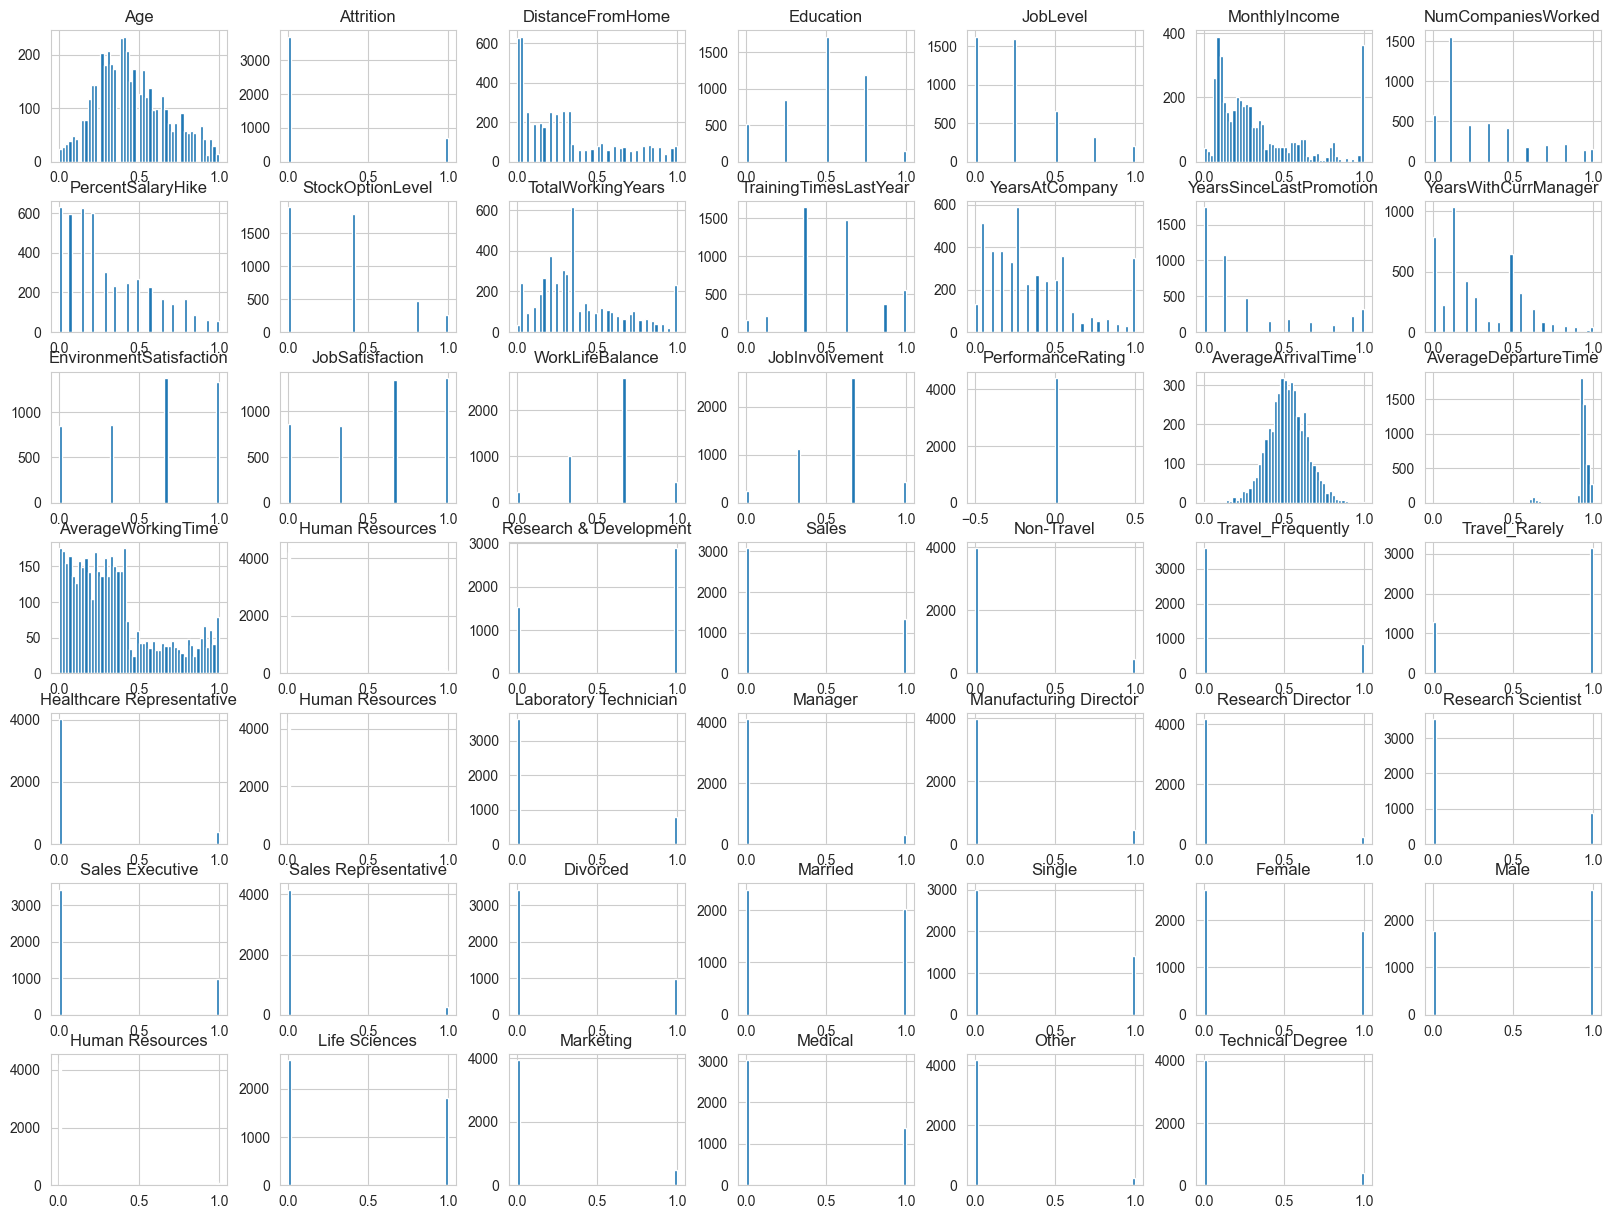

In [439]:
# Display the first 5 rows of the data
print(full_employee_data.head())

# Display the shape of the data
print(full_employee_data.shape)

# Display the columns of the data
print(full_employee_data.columns)

# Display the summary statistics of the data
print(full_employee_data.describe(include='all'))

# Display the missing values in the data
print(full_employee_data.isnull().sum())

# Display the unique values in the data
full_employee_data.hist(bins=50, figsize=(20, 15))
plt.show()

                             Age  TotalWorkingYears  YearsAtCompany  \
Age                          NaN           0.678390             NaN   
TotalWorkingYears        0.67839                NaN        0.595742   
YearsAtCompany               NaN           0.595742             NaN   
YearsSinceLastPromotion      NaN                NaN        0.589700   
YearsWithCurrManager         NaN                NaN        0.833621   
Human Resources              NaN                NaN             NaN   
Research & Development       NaN                NaN             NaN   
Sales                        NaN                NaN             NaN   
Non-Travel                   NaN                NaN             NaN   
Travel_Frequently            NaN                NaN             NaN   
Travel_Rarely                NaN                NaN             NaN   
Married                      NaN                NaN             NaN   
Single                       NaN                NaN             NaN   
Female

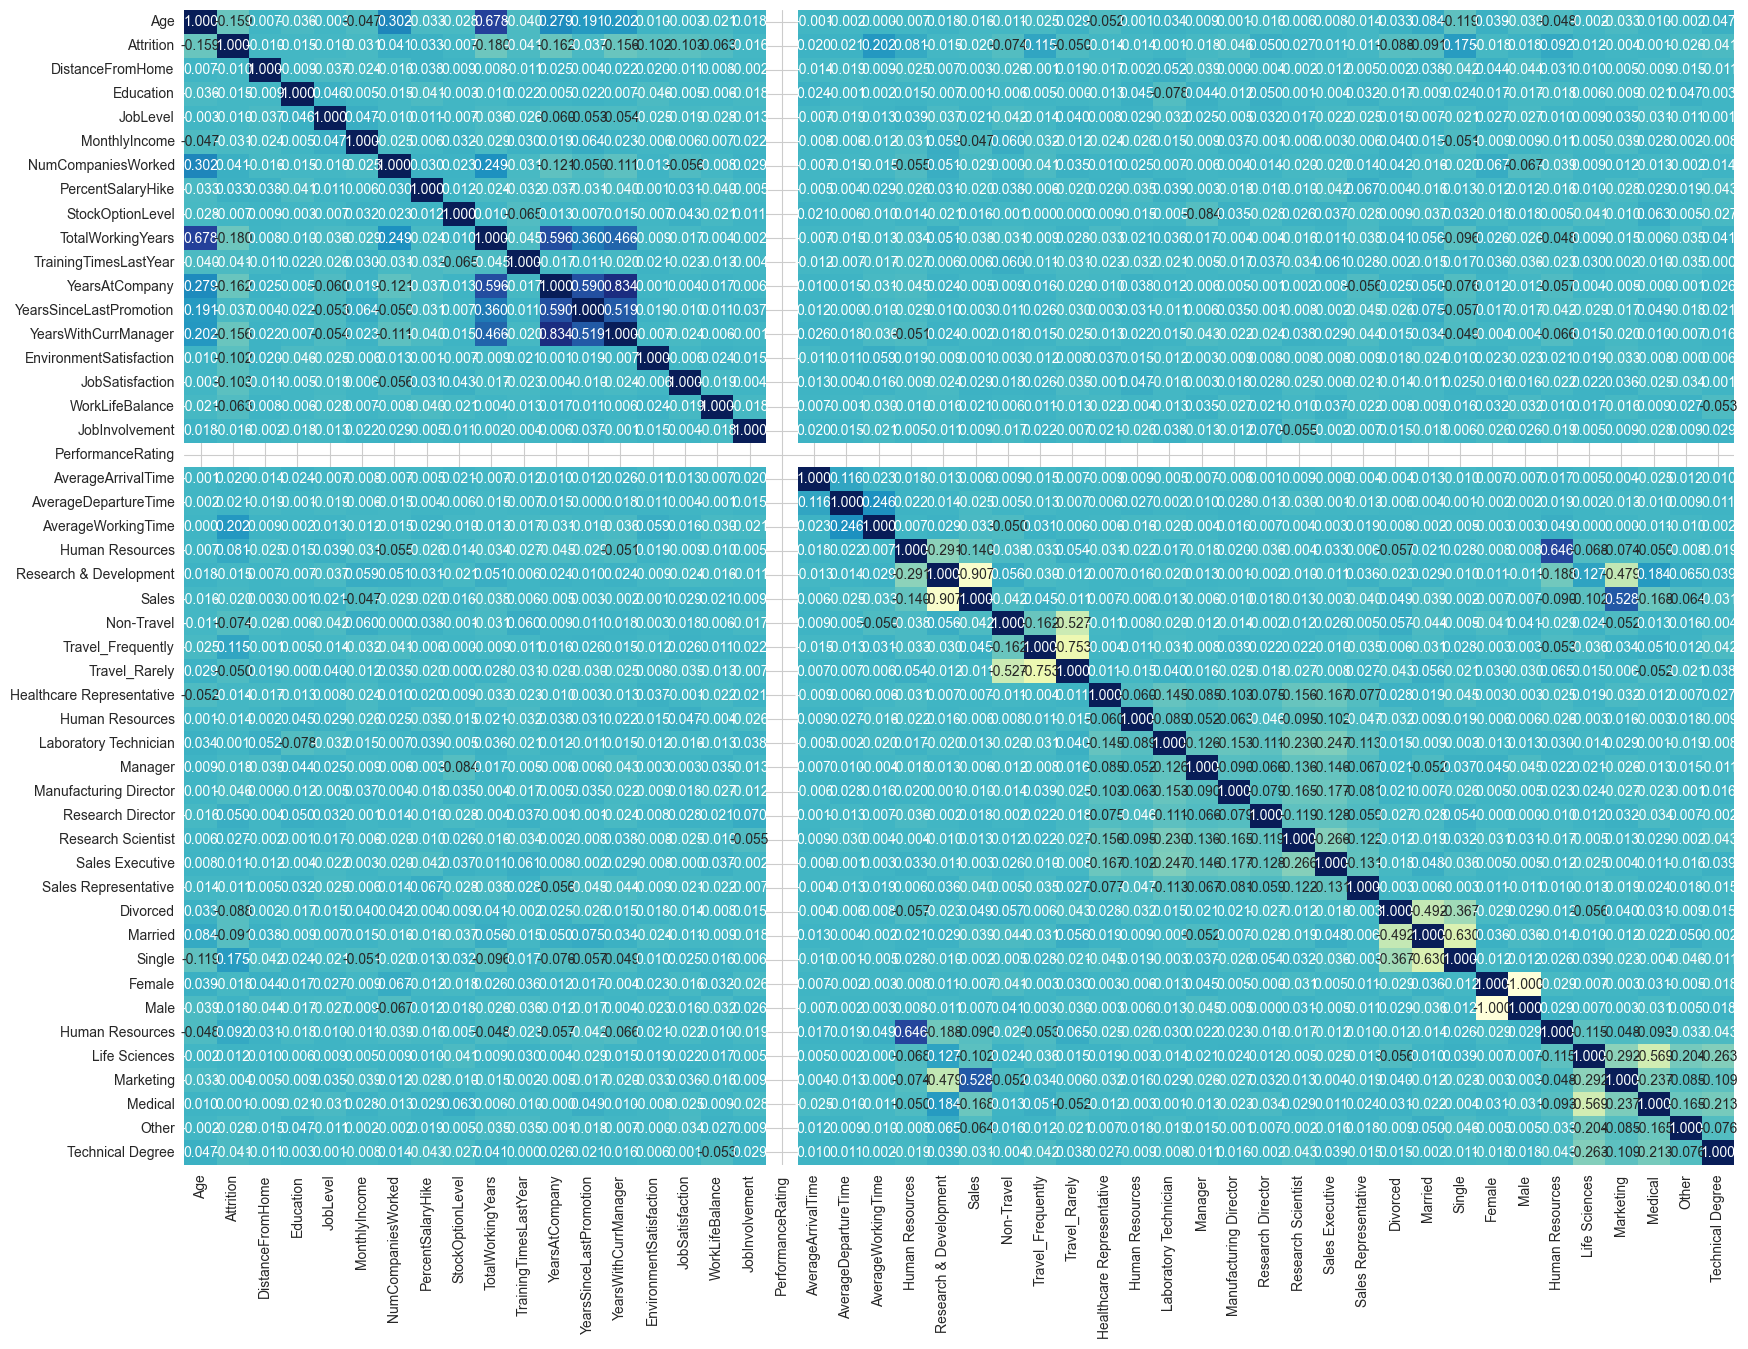

In [440]:
# Display the correlation matrix of the data
corr_matrix = full_employee_data.corr()

# Print the correlation of each data which is greater than 0.5 absolute
high_corr = corr_matrix[(np.abs(corr_matrix) > 0.5) & (corr_matrix != 1.0)]
print(high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1))

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 15), edgecolor='white')
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='YlGnBu', cbar=False)
plt.show()

In [441]:
full_employee_data.to_csv('full_employee_data_cleaned.csv', index=False)